# K-Means from Scratch for Ishihara Test

This notebook implements the K-Means clustering algorithm from scratch and uses it to attempt to extract the number from an Ishihara color blindness test image.

**Steps:**
1.  **Upload Image:** Run the first code cell and use the 'Choose Files' button to upload your Ishihara test image (e.g., `ishihara_test.png`).
2.  **Run Imports and Definitions:** Execute the cells containing imports, the `KMeans` class, and the `display_images` helper function.
3.  **Load & Prepare Image:** Run the cell that loads the uploaded image and prepares it for K-means.
4.  **Run K-Means:** Execute the cell that runs the K-means algorithm and displays the original vs. quantized image.
5.  **Extract Number:** Examine the quantized image and the printed centroid colors. Run the final cell and enter the cluster index that appears to represent the number when prompted. A mask highlighting that cluster will be shown.

In [45]:
# Step 1: Upload the Ishihara Test Image
from google.colab import files
import os

print('Please upload your Ishihara test image:')
uploaded = files.upload()

# Get the filename of the uploaded file
if not uploaded:
  raise ValueError("No file uploaded. Please re-run the cell and upload an image.")
else:
  # Get the first uploaded filename (assuming only one file)
  img_filename = next(iter(uploaded))
  print(f'\nSuccessfully uploaded: {img_filename}')

  # Define the path where Colab stores the uploaded file
  img_path = img_filename # In Colab's root temporary directory

  # Verify the file exists at the expected path
  if not os.path.exists(img_path):
    print(f"Error: Uploaded file '{img_path}' not found. Check Colab's file browser.")
  else:
    print(f"Image path set to: {img_path}")

Please upload your Ishihara test image:


Saving 74.jpg to 74.jpg

Successfully uploaded: 74.jpg
Image path set to: 74.jpg


## Step 2: Imports and Algorithm Definitions

In [11]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [12]:
# --- K-Means Class Definition ---
class KMeans:
    """
    K-Means clustering algorithm implemented from scratch.
    """
    def __init__(self, k=3, max_iters=100, tol=1e-4):
        """
        Initializes the KMeans instance.

        Args:
            k (int): The number of clusters.
            max_iters (int): Maximum number of iterations to run.
            tol (float): Tolerance for centroid movement to declare convergence.
                         (Sum of squared distances between old and new centroids).
        """
        if k <= 0:
            raise ValueError("Number of clusters 'k' must be positive.")
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None # Shape: (k, n_features)
        self.labels = None    # Shape: (n_samples,) - Stores cluster index for each sample
        self.inertia_ = None  # Sum of squared distances of samples to their closest cluster center.

    def _euclidean_distance(self, point1, point2):
        """Calculates the squared Euclidean distance between two points."""
        # Using squared distance is common and avoids sqrt, doesn't change closest point
        return np.sum((point1 - point2)**2)

    def fit(self, X):
        """
        Computes K-means clustering.

        Args:
            X (np.ndarray): Training data, shape (n_samples, n_features).
        """
        n_samples, n_features = X.shape

        # --- 1. Initialization ---
        # Select k random unique data points as initial centroids
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = X[random_indices]

        for i in range(self.max_iters):
            # --- 2. Assignment Step ---
            self.labels = np.zeros(n_samples, dtype=int)
            distances = np.zeros((n_samples, self.k))

            # Calculate distance from each point to each centroid
            for k_idx, centroid in enumerate(self.centroids):
                distances[:, k_idx] = np.sum((X - centroid)**2, axis=1) # Optimized distance calc

            # Assign each point to the closest centroid
            self.labels = np.argmin(distances, axis=1)

            # --- 3. Update Step ---
            new_centroids = np.zeros((self.k, n_features))
            for k_idx in range(self.k):
                # Get all points assigned to this cluster
                cluster_points = X[self.labels == k_idx]

                # Calculate the mean of the cluster points
                if len(cluster_points) > 0:
                    new_centroids[k_idx] = np.mean(cluster_points, axis=0)
                else:
                    # Handle empty cluster: Re-initialize centroid randomly
                    print(f"Warning: Cluster {k_idx} became empty at iteration {i}. Re-initializing.")
                    new_centroids[k_idx] = X[np.random.choice(n_samples)]


            # --- 4. Convergence Check ---
            # Calculate the total squared distance moved by centroids
            centroid_shift = np.sum((new_centroids - self.centroids)**2)
            self.centroids = new_centroids # Update centroids

            if centroid_shift < self.tol:
                print(f"Converged after {i+1} iterations.")
                break
        else: # Runs if the loop completes without break (max_iters reached)
             print(f"Warning: K-means did not converge within {self.max_iters} iterations.")

        # Calculate inertia (sum of squared distances to closest centroid)
        self.inertia_ = 0
        for k_idx in range(self.k):
            cluster_points = X[self.labels == k_idx]
            if len(cluster_points) > 0:
                self.inertia_ += np.sum((cluster_points - self.centroids[k_idx])**2)

        print(f"Final Inertia: {self.inertia_:.4f}")


    def predict(self, X):
        """
        Predicts the closest cluster each sample in X belongs to.

        Args:
            X (np.ndarray): New data points, shape (n_samples, n_features).

        Returns:
            np.ndarray: Index of the cluster each sample belongs to.
        """
        if self.centroids is None:
            raise Exception("Model has not been fitted yet. Call fit() first.")

        n_samples = X.shape[0]
        distances = np.zeros((n_samples, self.k))

        # Calculate distance from each point to each *final* centroid
        for k_idx, centroid in enumerate(self.centroids):
             distances[:, k_idx] = np.sum((X - centroid)**2, axis=1)

        # Assign each point to the closest centroid
        return np.argmin(distances, axis=1)

    def get_quantized_image(self, X_original_shape):
        """
        Creates an image where each pixel is replaced by its assigned centroid color.

        Args:
            X_original_shape (tuple): The original shape of the image (height, width, channels).

        Returns:
            np.ndarray: The quantized image with the original shape.
        """
        if self.centroids is None or self.labels is None:
            raise Exception("Model has not been fitted yet. Call fit() first.")

        # Create a new array to store the quantized image data
        quantized_X = np.zeros((len(self.labels), self.centroids.shape[1]))

        # Replace each pixel's value with its assigned centroid's value
        for k_idx in range(self.k):
            quantized_X[self.labels == k_idx] = self.centroids[k_idx]

        # Reshape back to the original image dimensions
        quantized_image = quantized_X.reshape(X_original_shape)

        return quantized_image

In [13]:
# --- Helper function for visualization ---
def display_images(original_img, quantized_img, k, mask=None, title_suffix=""):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    # Clip values to be safe for display (0-1 for float, 0-255 for int)
    if quantized_img.dtype == np.float64 or quantized_img.dtype == np.float32:
         quantized_img_display = np.clip(quantized_img, 0, 1)
    else:
         quantized_img_display = np.clip(quantized_img, 0, 255)
    plt.imshow(quantized_img_display)
    plt.title(f'Quantized Image (K={k}){title_suffix}')
    plt.axis('off')

    if mask is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Potential Number Mask (K={k}){title_suffix}')
        plt.axis('off')
    else:
        # Keep the layout consistent even if no mask
        ax = plt.subplot(1, 3, 3)
        ax.axis('off') # Turn off axis for the empty subplot
        ax.text(0.5, 0.5, '(Mask will appear here)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


    plt.tight_layout()
    plt.show()

## Step 3: Load and Prepare the Image

Image was uint8, normalized to [0, 1] float32.
Original image shape: (300, 300, 3)
Reshaped pixel data shape: (90000, 3)


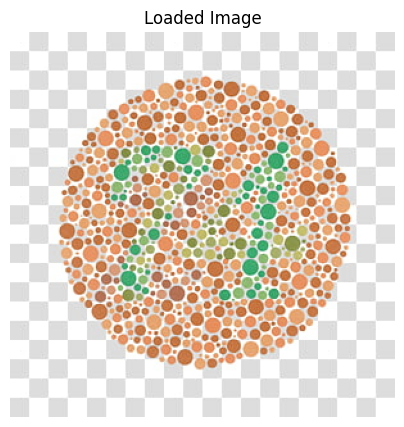

In [46]:
# --- Load the Ishihara Image ---

# Check if img_path was defined in the first cell
if 'img_path' not in locals() or not os.path.exists(img_path):
  raise NameError("Image path not defined or file doesn't exist. Please run the first cell to upload the image.")

try:
    img = mpimg.imread(img_path)
except Exception as e:
    print(f"Error reading image file '{img_path}': {e}")
    raise # Re-raise the exception

# --- Preprocessing ---
# Images read by matplotlib are often float32 in [0, 1] range.
# If it's uint8 [0, 255], normalize it.
is_normalized = False
if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255.0
    is_normalized = True
    print("Image was uint8, normalized to [0, 1] float32.")
elif img.max() > 1.0:
    # Handle cases where it might be float but not in [0,1]
    print(f"Warning: Image is float but max value {img.max()} > 1.0. Assuming it's [0, 255] and normalizing.")
    img = img.astype(np.float32) / 255.0
    is_normalized = True

# K-means works on data points (pixels) with features (color channels)
original_shape = img.shape
print(f"Original image shape: {original_shape}")

# Reshape the image into a 2D array: (num_pixels, num_channels)
# Ignore alpha channel if present (e.g., PNGs)
if len(original_shape) == 3 and original_shape[2] > 3:
    print("Image has more than 3 channels (likely Alpha), using only RGB.")
    img = img[:, :, :3]
    original_shape = img.shape # Update shape
elif len(original_shape) == 2:
    # Handle grayscale images by adding a channel dimension
    print("Image is grayscale. Expanding dimensions for K-means (treating intensity as a feature).")
    img = np.expand_dims(img, axis=-1)
    original_shape = img.shape

pixels = img.reshape(-1, original_shape[2]) # Reshape to (height*width, channels)
print(f"Reshaped pixel data shape: {pixels.shape}")

# Display the loaded image to confirm
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(img, 0, 1)) # Clip just in case
plt.title("Loaded Image")
plt.axis('off')
plt.show()

## Step 4: Run K-Means Clustering

Choose a value for `k`. For Ishihara plates, `k=4` or `k=5` often works well to separate background dot colors from number dot colors, but you might need to experiment.


Running K-means with K=4...
Converged after 5 iterations.
Final Inertia: 1029.1793


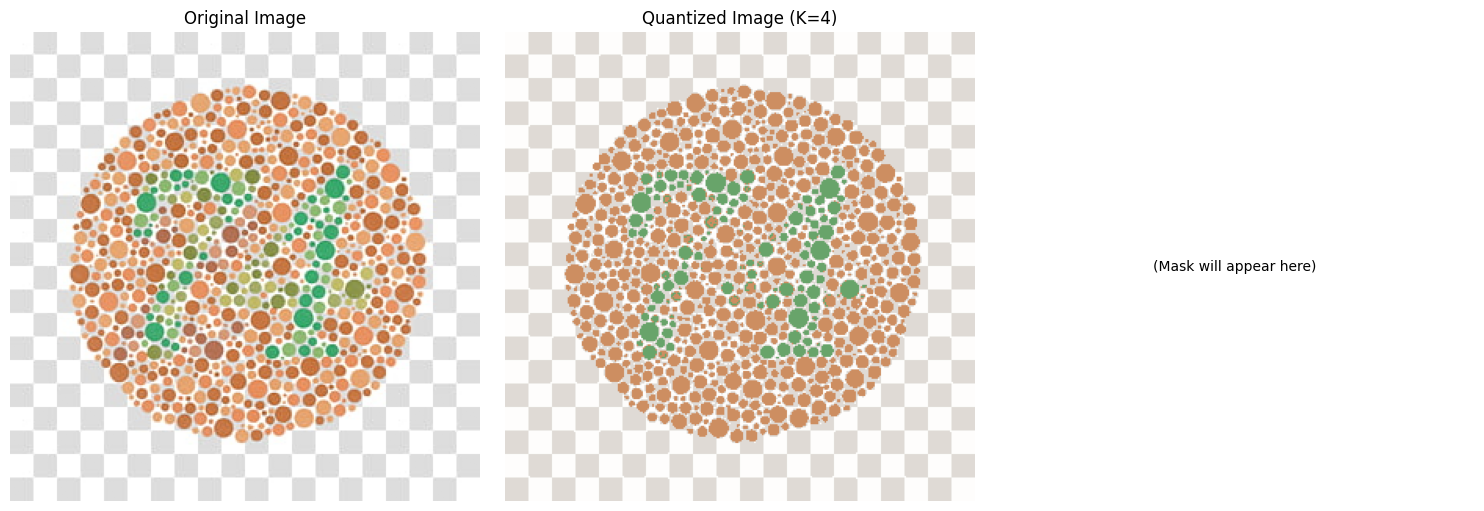


Cluster Centroid Colors (RGB - range depends on original image scale):
(Displaying as approx 0-255 scale)
Cluster 0: [254 253 252]
Cluster 1: [205 142  97]
Cluster 2: [104 164 106]
Cluster 3: [223 218 213]

Examine the 'Quantized Image' and the centroid colors above.
Identify the index (0, 1, 2, ...) of the cluster that seems to represent the hidden number.


In [49]:
# --- Run K-means ---

# !!! --- EXPERIMENT WITH THIS VALUE --- !!!
k_value = 4 # Try values like 3, 4, 5, 6
# !!! ------------------------------------ !!!

print(f"\nRunning K-means with K={k_value}...")
kmeans = KMeans(k=k_value, max_iters=150, tol=1e-4)
kmeans.fit(pixels)

# --- Visualize the Results ---
# Get the quantized image (pixels replaced by their centroid colors)
quantized_image = kmeans.get_quantized_image(original_shape)

# Display original and quantized images
display_images(np.clip(img, 0, 1), quantized_image, k_value)

# --- Print Centroid Information ---
print("\nCluster Centroid Colors (RGB - range depends on original image scale):")
if is_normalized: # If we normalized to [0, 1] earlier
  centroids_display = (kmeans.centroids * 255).astype(int)
  print("(Displaying as approx 0-255 scale)")
else:
  centroids_display = kmeans.centroids.astype(int)
  print("(Displaying in original image scale)")

# Print centroids with their index
for idx, centroid in enumerate(centroids_display):
    print(f"Cluster {idx}: {centroid}")

print("\nExamine the 'Quantized Image' and the centroid colors above.")
print("Identify the index (0, 1, 2, ...) of the cluster that seems to represent the hidden number.")

## Step 5: Extract the Number (Heuristic)

Based on the results above, enter the cluster index you think corresponds to the number in the prompt that appears when you run the next cell.

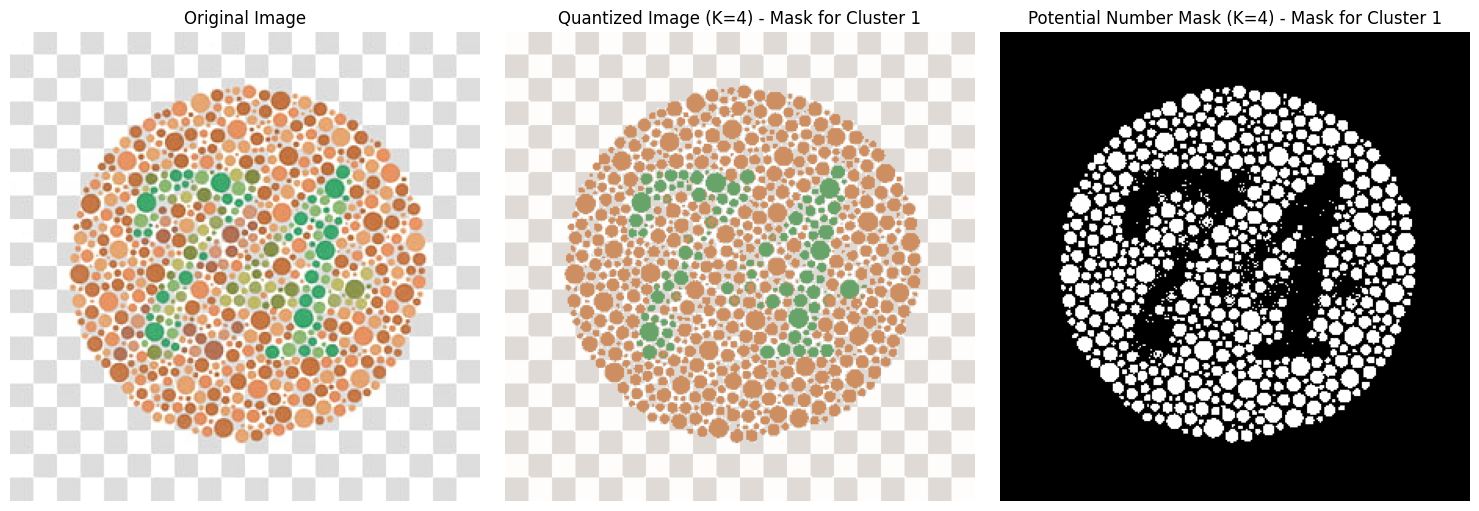


Displayed a mask image. If the index 1 was correct,
the number should be visible in white against a black background in the 'Potential Number Mask' plot.
If not, try running the previous cell again with a different 'k_value' or re-run this cell and choose a different cluster index.


In [50]:
# --- Attempt to Extract the Number (Semi-Manual/Heuristic) ---

# **Manual Step / Heuristic:** Look at the quantized image and the centroid colors.
# Identify which cluster index (or indices) seem to correspond to the number.

try:
    # ---- !!! ----
    # ---- !!! --> YOU NEED TO ENTER THE INDEX BASED ON YOUR RESULTS <-- !!! ----
    # ---- !!! ----
    number_cluster_index = 1

    if not (0 <= number_cluster_index < k_value):
        raise ValueError("Invalid index entered.")

    # Create a binary mask: 1 for pixels in the number cluster, 0 otherwise
    mask = np.zeros(pixels.shape[0], dtype=np.uint8)
    mask[kmeans.labels == number_cluster_index] = 1 # Set pixels belonging to the cluster to 1

    # Reshape mask back to image dimensions
    # Ensure mask shape matches image height and width
    mask_image = mask.reshape(original_shape[0], original_shape[1])

    # Display the original, quantized, and the final mask
    display_images(np.clip(img, 0, 1),
                   quantized_image,
                   k_value,
                   mask=mask_image,
                   title_suffix=f" - Mask for Cluster {number_cluster_index}")

    print(f"\nDisplayed a mask image. If the index {number_cluster_index} was correct,")
    print("the number should be visible in white against a black background in the 'Potential Number Mask' plot.")
    print("If not, try running the previous cell again with a different 'k_value' or re-run this cell and choose a different cluster index.")

except ValueError as e:
     print(f"\nError: Invalid input. Please enter an integer between 0 and {k_value-1}. Details: {e}")
except NameError as e:
     print(f"\nError: It seems the K-means model hasn't been run yet. Please execute the previous cells first. Details: {e}")
except Exception as e:
     print(f"\nAn unexpected error occurred during mask generation: {e}")
